## **Data Cleaning**

In [1]:
!pip install pandas==0.25

     |████████████████████████████████| 10.4MB 13.7MB/s 
ERROR: xarray 0.18.2 has requirement pandas>=1.0, but you'll have pandas 0.25.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.0 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.25.0 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [66]:
#Importing the libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import math
import re 
import pandas_profiling as pp
from sklearn import cluster
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [67]:
#Loading our data set

raw_data = pd.read_excel('/content/sample_data/Longlist.xlsx') #load raw dataset 

In [68]:
#Using Pandas Profiling to get initial insights

pp.ProfileReport(raw_data) 

Number of variables,18
Number of observations,1839
Total Missing (%),2.8%
Total size in memory,258.7 KiB
Average record size in memory,144.1 B
Numeric,5
Categorical,7
Boolean,0
Date,0
Text (Unique),3
Rejected,3


In [69]:
#Getting column names of our data set

raw_data.columns

Index(['Date Added', 'category', 'sellerlink', 'sellerlink-url',
       'sellerstorefront-url', 'sellerproductcount', 'sellerratings',
       'sellerdetails', 'seller business name', 'businessaddress',
       'Count of seller brands',
       'Max % of negative seller ratings - last 30 days',
       'Max % of negative seller ratings - last 90 days',
       'Max % of negative seller ratings - last 12 months',
       'Hero Product 1 #ratings', 'Hero Product 2 #ratings',
       'Sample brand name', 'Sample Brand URL'],
      dtype='object')

In [70]:
#Checking the shape of our data

raw_data.shape

(1839, 18)

In [71]:
#Checking the data type of each column

raw_data.dtypes

Date Added                                           datetime64[ns]
category                                                     object
sellerlink                                                   object
sellerlink-url                                               object
sellerstorefront-url                                         object
sellerproductcount                                           object
sellerratings                                                object
sellerdetails                                                object
seller business name                                         object
businessaddress                                              object
Count of seller brands                                        int64
Max % of negative seller ratings - last 30 days               int64
Max % of negative seller ratings - last 90 days               int64
Max % of negative seller ratings - last 12 months             int64
Hero Product 1 #ratings                         

In [72]:
#Selecting specific columns to get a reduced data set

reduced_data = raw_data[["sellerproductcount","sellerratings","sellerdetails","businessaddress","Count of seller brands","Max % of negative seller ratings - last 30 days","Max % of negative seller ratings - last 90 days","Max % of negative seller ratings - last 12 months","Hero Product 1 #ratings","Hero Product 2 #ratings"]]

In [73]:
#Checking the columns of the reduced data set

reduced_data.columns 

Index(['sellerproductcount', 'sellerratings', 'sellerdetails',
       'businessaddress', 'Count of seller brands',
       'Max % of negative seller ratings - last 30 days',
       'Max % of negative seller ratings - last 90 days',
       'Max % of negative seller ratings - last 12 months',
       'Hero Product 1 #ratings', 'Hero Product 2 #ratings'],
      dtype='object')

In [74]:
#Checking the shape of our reduced data set

reduced_data.shape 

(1839, 10)

In [75]:
#Checking the data type each column in our reduced data set 

reduced_data.dtypes 

sellerproductcount                                   object
sellerratings                                        object
sellerdetails                                        object
businessaddress                                      object
Count of seller brands                                int64
Max % of negative seller ratings - last 30 days       int64
Max % of negative seller ratings - last 90 days       int64
Max % of negative seller ratings - last 12 months     int64
Hero Product 1 #ratings                               int64
Hero Product 2 #ratings                               int64
dtype: object

In [76]:
#Finding the number of missing (NaN) values in individual columns

reduced_data.isna().sum()   

sellerproductcount                                   326
sellerratings                                        428
sellerdetails                                         27
businessaddress                                       75
Count of seller brands                                 0
Max % of negative seller ratings - last 30 days        0
Max % of negative seller ratings - last 90 days        0
Max % of negative seller ratings - last 12 months      0
Hero Product 1 #ratings                                0
Hero Product 2 #ratings                                0
dtype: int64

In [77]:
#Creating a dataframe with out reduced data set and dropping Seller details column

parsed_data = pd.DataFrame(reduced_data)
parsed_data = parsed_data.drop(columns = ["sellerdetails"])

In [78]:
parsed_data.head()

,sellerproductcount,sellerratings,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings
0,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,5873,4957
1,NaN,90% positive in the last 12 months (566 ratings),1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,0,0
2,"1-16 of over 2,000 results",85% positive in the last 12 months (75 ratings),zhongnanshijicheng27zhuang1410haochongchuanqun...,15,0,25,12,164,162
3,1-16 of 123 results,NaN,河南省中兴南路福禄街自贸试验区郑州片区（郑东）河南商会大厦1901室450000CN,1,0,0,0,0,0
4,"1-16 of over 1,000 results",81% positive in the last 12 months (52 ratings),minzhidadaoshaxialaocun94dongA901longhuaxinqus...,16,0,31,15,224,113


In [79]:
##Parsing the Seller Product column


#Splitting the Seller Product column string and extracting the product count if the value is not NaN

parsed_data["sellerproductcount"] = reduced_data["sellerproductcount"].apply(lambda x: x.split(" ")[-2] if x is not np.nan else np.nan) 

#Changing the string values to float if the value is not NaN

parsed_data["sellerproductcount"] = parsed_data["sellerproductcount"].apply(lambda x: (int("".join(x.split(","))) if "," in x else int(x)) if x is not np.nan else np.nan)

#Replacing the NaN values with the mean of the product count 

parsed_data["sellerproductcount"] = parsed_data["sellerproductcount"].fillna(parsed_data["sellerproductcount"].mean())

In [80]:
##Parsing the Seller Ratings column


#Extracting the positivity rating for each seller to get a normalized score

parsed_data["sellerratings"] = reduced_data["sellerratings"].apply(lambda x: int(x.split(" ")[0].rstrip("%"))/100 if x is not np.nan else np.nan) 

#Replacing NaN values with mean seller ratings

parsed_data["sellerratings"] = parsed_data["sellerratings"].fillna(parsed_data["sellerratings"].mean())

In [81]:
##Creating new columns with seller details


#Parsing seller emails and putting the string "no email" if no email id is found 

parsed_data["selleremails"] = reduced_data["sellerdetails"].apply(lambda x: re.findall(r'[\w\.-]+@[\w\.-]+', x) if x is not np.nan else "no email")
parsed_data["selleremails"] = parsed_data["selleremails"].apply(lambda x: x[0] if len(x) > 0 and x != "no email" else "no email")

#Parsing seller phone numbers and puting the string "no phone" if no number is found 

parsed_data["sellerphonenumber"] = reduced_data["sellerdetails"].apply(lambda x: re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', x) if x is not np.nan else "no phone")
parsed_data["sellerphonenumber"] = parsed_data["sellerphonenumber"].apply(lambda x: x if len(x) > 0 and x != "no phone" else "no phone")


In [82]:
parsed_data.head()

,sellerproductcount,sellerratings,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,selleremails,sellerphonenumber
0,100000.000000,0.880000,411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,5873,4957,jadgemaello@gmail.com,"[10022-6630, +1208-964-6807, 10022-6630, +1208..."
1,6150.933245,0.900000,1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,0,0,info@1a-handelsagentur.de,"[39932-829721, 39932 - 829721]"
2,2000.000000,0.850000,zhongnanshijicheng27zhuang1410haochongchuanqun...,15,0,25,12,164,162,no email,no phone
3,123.000000,0.809837,河南省中兴南路福禄街自贸试验区郑州片区（郑东）河南商会大厦1901室450000CN,1,0,0,0,0,0,no email,no phone
4,1000.000000,0.810000,minzhidadaoshaxialaocun94dongA901longhuaxinqus...,16,0,31,15,224,113,no email,no phone


In [83]:
#Checking the shape of our parsed dataframe

parsed_data.shape

(1839, 11)

In [84]:
#Checking for NaN values

parsed_data.isna().sum()

sellerproductcount                                    0
sellerratings                                         0
businessaddress                                      75
Count of seller brands                                0
Max % of negative seller ratings - last 30 days       0
Max % of negative seller ratings - last 90 days       0
Max % of negative seller ratings - last 12 months     0
Hero Product 1 #ratings                               0
Hero Product 2 #ratings                               0
selleremails                                          0
sellerphonenumber                                     0
dtype: int64

In [85]:
#Shape before dropping observations

parsed_data.shape

(1839, 11)

In [86]:
#Dropping rows with Nan business address

parsed_data = parsed_data.dropna()

In [87]:
#Dropping rows with business address in China

parsed_data = parsed_data[["CN" not in x for x in parsed_data["businessaddress"]]]  

In [88]:
#Shape after dropping observations

parsed_data.shape

(525, 11)

### Clustering Analysis

In [89]:
#Preparing a new dataset for clustering 

cluster_set = parsed_data[["sellerproductcount","sellerratings","Count of seller brands","Hero Product 1 #ratings","Hero Product 2 #ratings","Max % of negative seller ratings - last 30 days", "Max % of negative seller ratings - last 90 days", "Max % of negative seller ratings - last 12 months"]]
scaler = preprocessing.StandardScaler().fit(cluster_set)
cluster_scaled = scaler.transform(cluster_set)
print(cluster_scaled.shape)


(525, 8)


In [90]:
#Finding the optimal value k using elbow method

losses = []
for i in range(1,10):
  k_means = cluster.KMeans(i)
  k_means.fit(cluster_scaled)
  losses.append(k_means.inertia_)

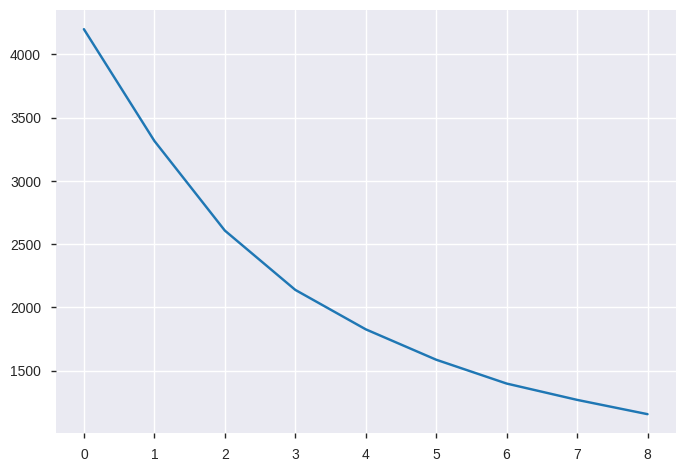

In [91]:
plt.plot(losses) # k = 2 has a slight elbow 

In [92]:
#Implementing K-means with 2 clusters

k_means = cluster.KMeans(2)
k_means.fit(cluster_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [93]:
#Implementing PCA to reduce data 2D to visualize data

pca_reduced = PCA(n_components=2).fit_transform(cluster_scaled)
print(pca_reduced.shape)

(525, 2)


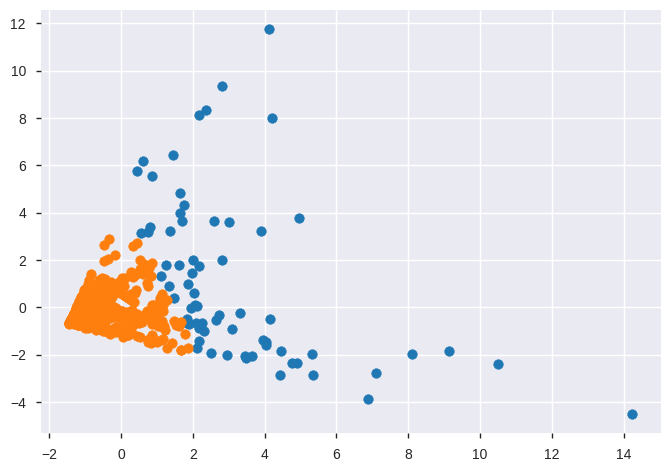

In [94]:
#Plotting our clusters 

for i in range(2):
  plt.scatter(pca_reduced[k_means.labels_ == i][:,0], pca_reduced[k_means.labels_ == i][:,1])
plt.show()

## **Analysis of Sanitized Dataset**

In [95]:
#Making a new dataframe to determine Max % of Negative Seller Ratings correlations

new_df = parsed_data[["Max % of negative seller ratings - last 30 days","Max % of negative seller ratings - last 90 days","Max % of negative seller ratings - last 12 months"]]

In [96]:
#Getting the correlation matrix of the three columns

new_df.corr()  

,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months
Max % of negative seller ratings - last 30 days,1.000000,0.731752,0.390195
Max % of negative seller ratings - last 90 days,0.731752,1.000000,0.541862
Max % of negative seller ratings - last 12 months,0.390195,0.541862,1.000000


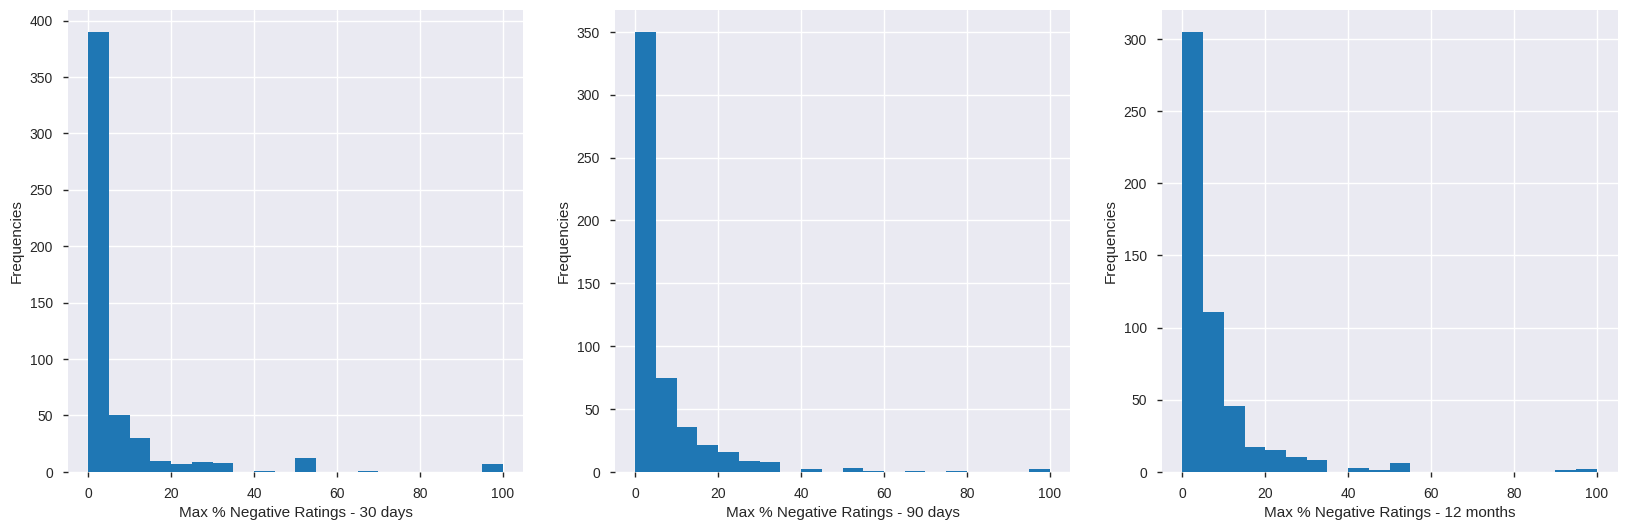

In [97]:
#Plotting individual Max % Negative ratings to understand each distribution

plot_30_days = new_df["Max % of negative seller ratings - last 30 days"].tolist()
plot_90_days = new_df["Max % of negative seller ratings - last 90 days"].tolist()
plot_12_months = new_df["Max % of negative seller ratings - last 12 months"].tolist()

fig = plt.figure(figsize= (20,6))
ax1 = fig.add_subplot(131)
ax1.hist(plot_30_days, bins = 20)
ax1.set_xlabel("Max % Negative Ratings - 30 days")
ax1.set_ylabel("Frequencies")
ax2 = fig.add_subplot(132)
ax2.hist(plot_90_days, bins = 20)
ax2.set_xlabel("Max % Negative Ratings - 90 days")
ax2.set_ylabel("Frequencies")
ax3 = fig.add_subplot(133)
ax3.hist(plot_12_months, bins = 20)
ax3.set_xlabel("Max % Negative Ratings - 12 months")
ax3.set_ylabel("Frequencies")
plt.show()

In [98]:
#Since the distributions are nearly similar, we can create a composite score of the three time periods.
#12 months time period gets the largest weight

parsed_data["Weighted Sum of % Negative Ratings"] = (0.0625*parsed_data["Max % of negative seller ratings - last 30 days"])+(0.1875*parsed_data["Max % of negative seller ratings - last 90 days"])+(0.75*parsed_data["Max % of negative seller ratings - last 12 months"])
parsed_data = parsed_data[["sellerproductcount", "sellerratings", "selleremails","sellerphonenumber", "businessaddress", "Count of seller brands", "Max % of negative seller ratings - last 30 days", "Max % of negative seller ratings - last 90 days", "Max % of negative seller ratings - last 12 months", "Weighted Sum of % Negative Ratings", "Hero Product 1 #ratings", "Hero Product 2 #ratings"]]


In [99]:
parsed_data.head(5)

,sellerproductcount,sellerratings,selleremails,sellerphonenumber,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Weighted Sum of % Negative Ratings,Hero Product 1 #ratings,Hero Product 2 #ratings
0,100000.000000,0.880000,jadgemaello@gmail.com,"[10022-6630, +1208-964-6807, 10022-6630, +1208...",411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,12.125,5873,4957
1,6150.933245,0.900000,info@1a-handelsagentur.de,"[39932-829721, 39932 - 829721]",1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,7.250,0,0
14,919.000000,0.970000,webmaster@9pm-store.de,[15140008562],Kaiserstr.12Borgholzhausen33829DE,15,0,0,3,2.250,1446,921
19,6150.933245,0.760000,abc-markt@web.de,no phone,Jösser Weg10Petershagen32469DE,0,18,20,20,19.875,0,0
20,123.000000,0.809837,no email,no phone,WEXFORDGOREY46 MAIN STY25T2N4IE,14,0,0,0,0.000,837,787


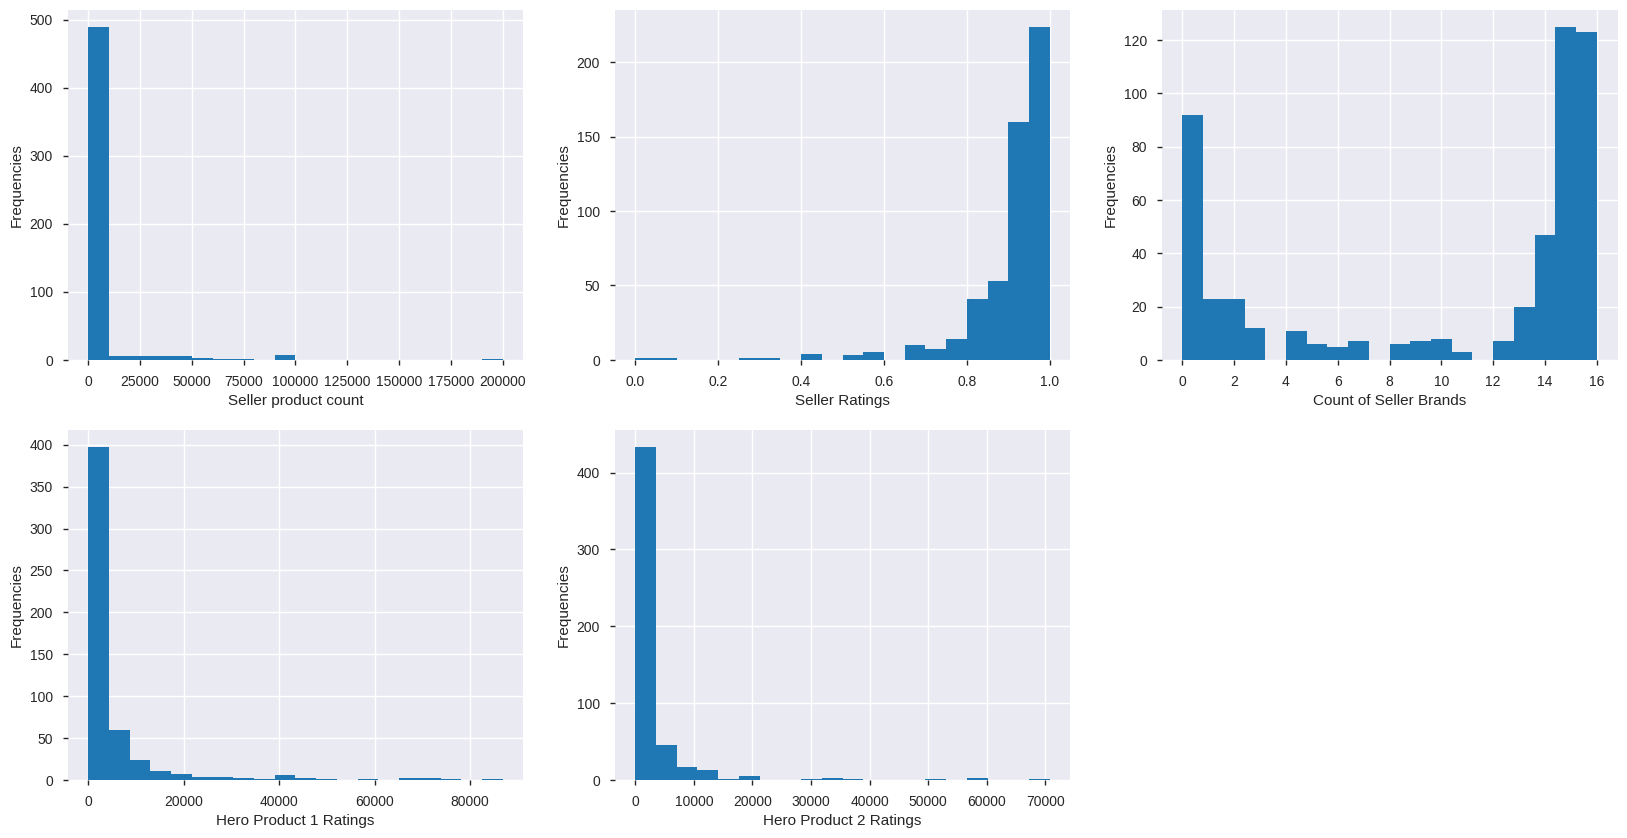

In [100]:
#Plotting the other 5 main columns to understand their distributions

first = parsed_data["sellerproductcount"]
second = parsed_data["sellerratings"]
third = parsed_data["Count of seller brands"]
fourth = parsed_data["Hero Product 1 #ratings"]
fifth = parsed_data["Hero Product 2 #ratings"]

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(231)
ax1.hist(first, bins = 20)
ax1.set_xlabel("Seller product count")
ax1.set_ylabel("Frequencies")
ax2 = fig.add_subplot(232)
ax2.hist(second, bins = 20)
ax2.set_xlabel("Seller Ratings")
ax2.set_ylabel("Frequencies")
ax3 = fig.add_subplot(233)
ax3.hist(third, bins = 20)
ax3.set_xlabel("Count of Seller Brands")
ax3.set_ylabel("Frequencies")
ax4 = fig.add_subplot(234)
ax4.hist(fourth, bins = 20)
ax4.set_xlabel("Hero Product 1 Ratings")
ax4.set_ylabel("Frequencies")
ax5 = fig.add_subplot(235)
ax5.hist(fifth, bins =  20)
ax5.set_xlabel("Hero Product 2 Ratings")
ax5.set_ylabel("Frequencies")


plt.show()

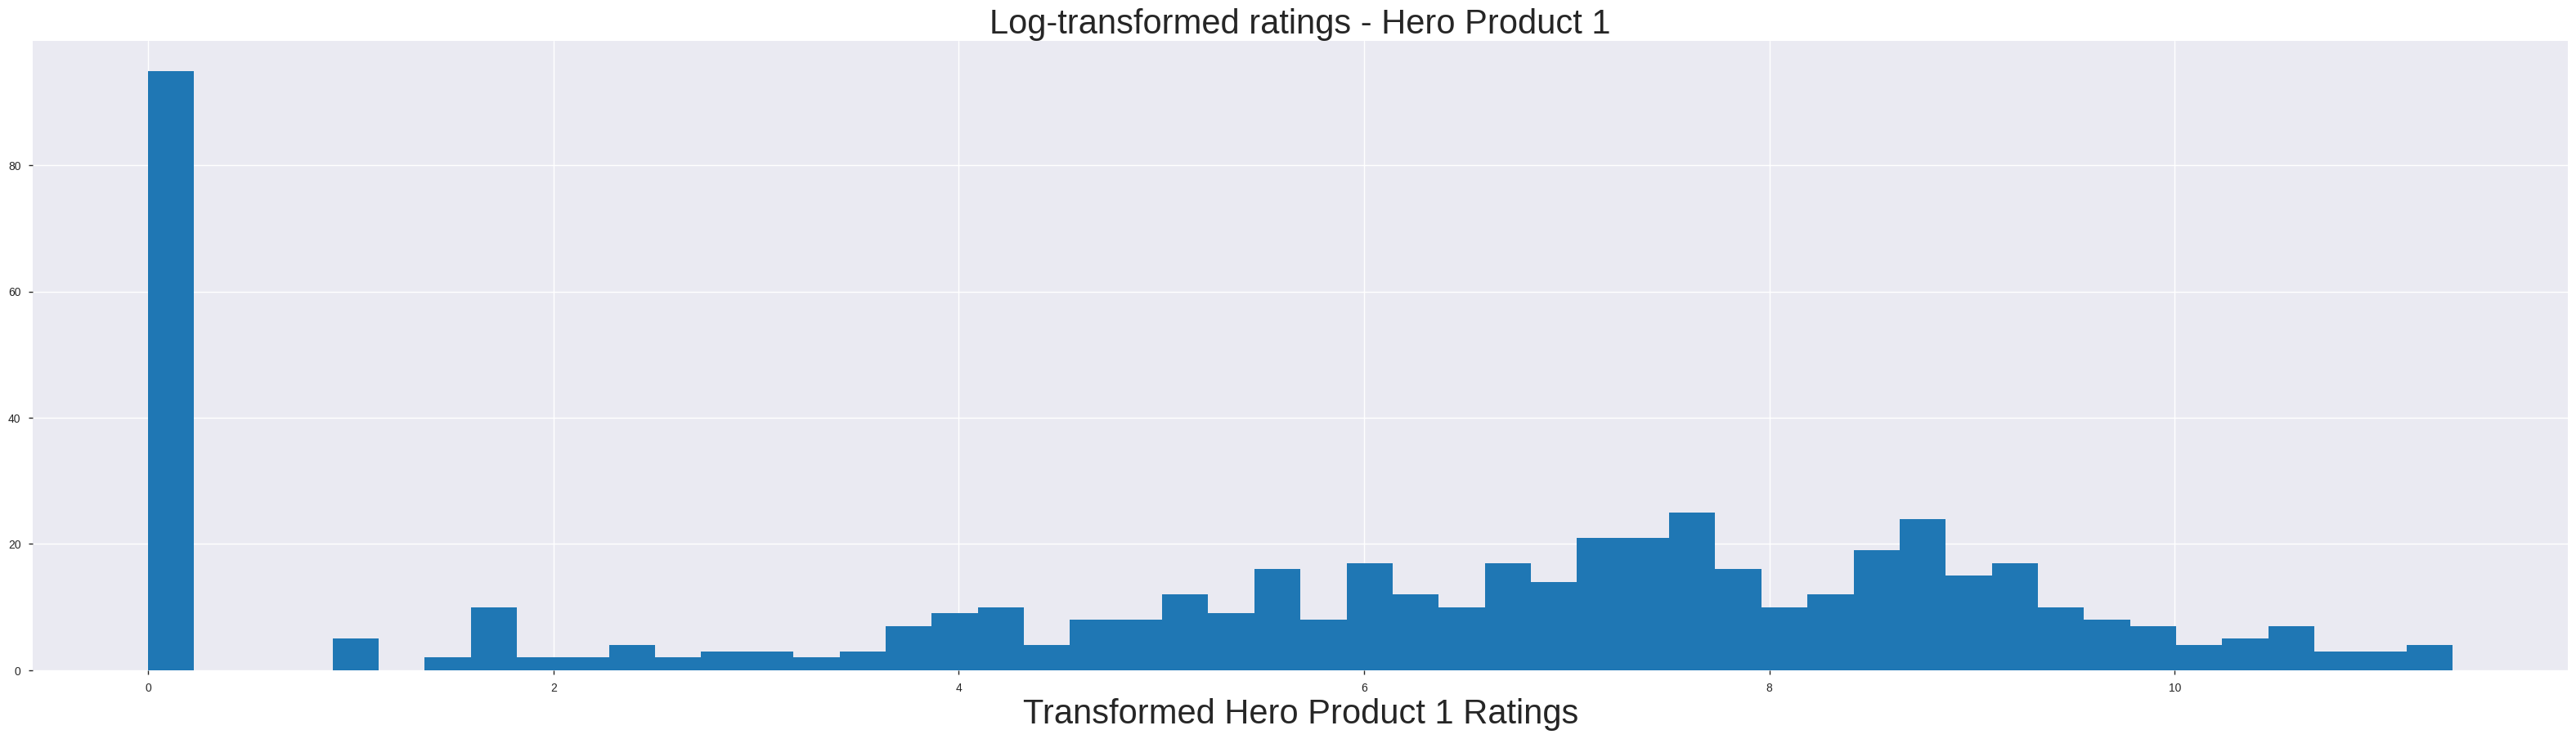

In [101]:
#Transforming Hero Product 1 ratings to draw better inference
#Log transformation helps in dealing with skewed data and decreases the effect of outliers

fourth = parsed_data["Hero Product 1 #ratings"]
fourth[fourth == 0] = 1
fourth = fourth.transform(np.log)
plt.figure(figsize = (40,10))
plt.title("Log-transformed ratings - Hero Product 1", size = 30)
plt.hist(fourth, bins = 50)
plt.xlabel("Transformed Hero Product 1 Ratings", size = 30)
plt.show()

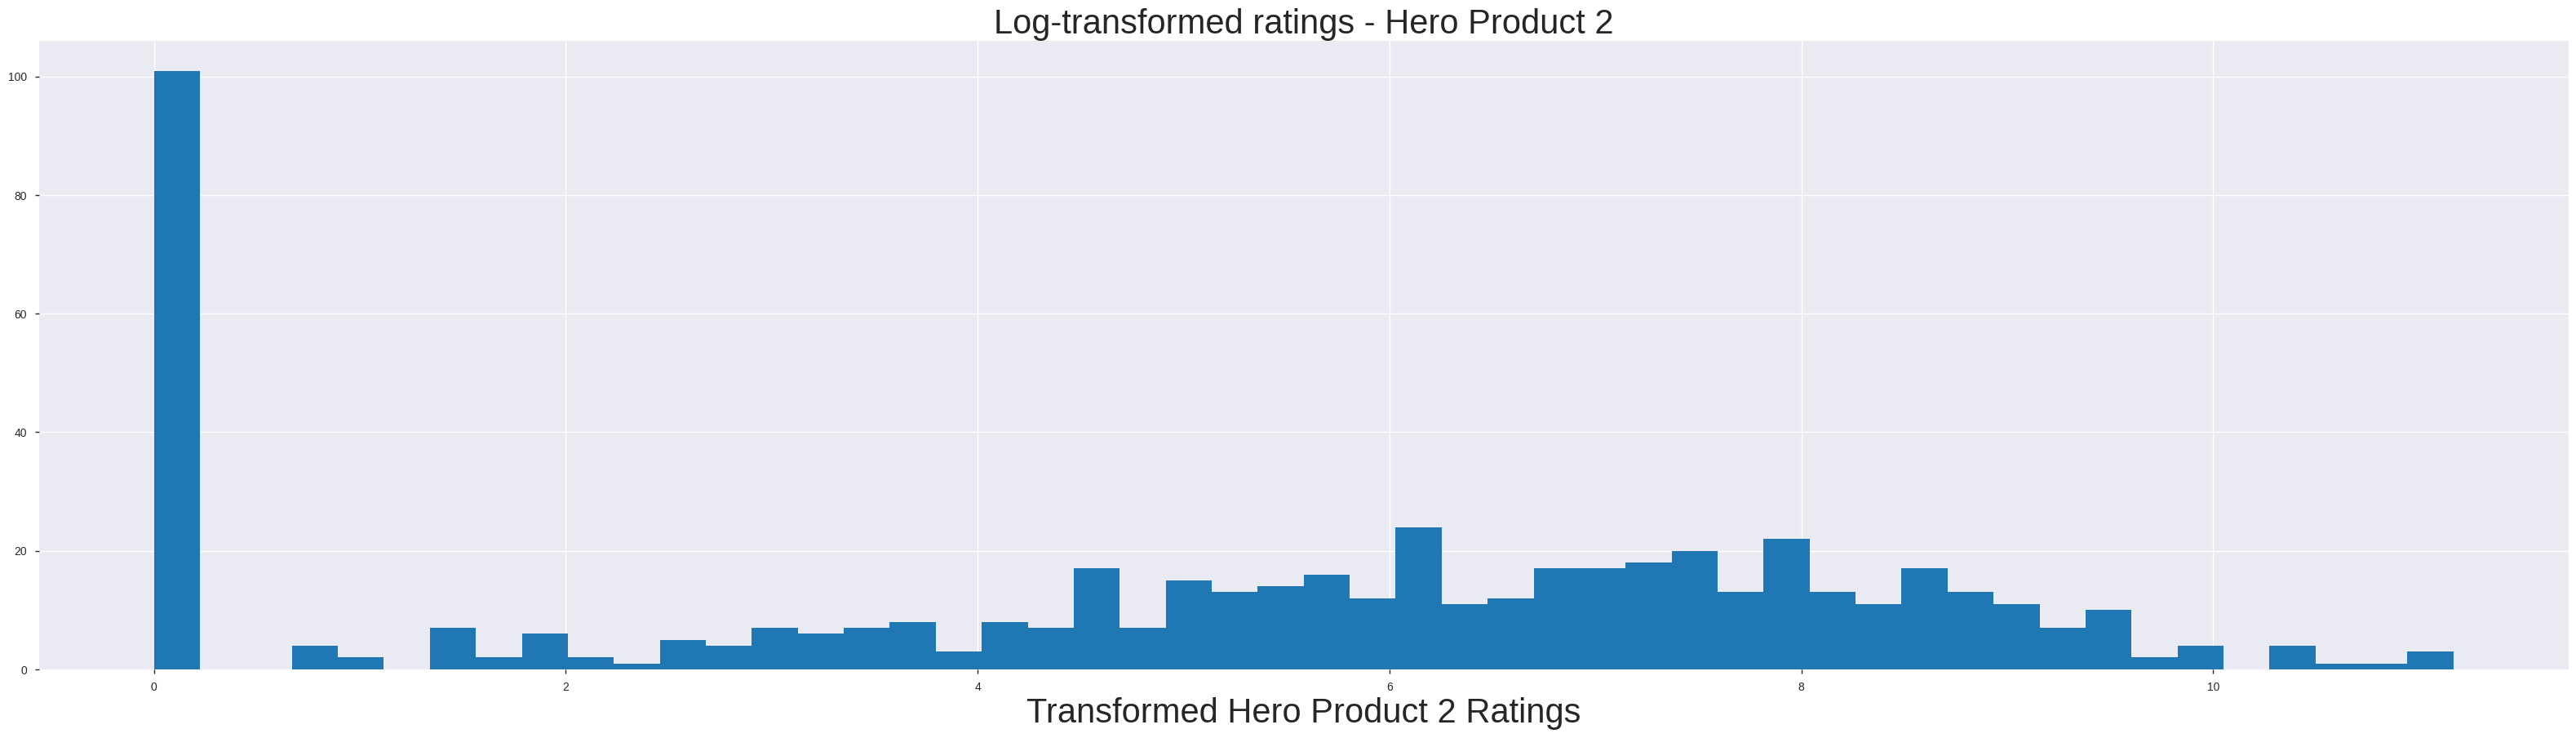

In [102]:
#Transforming Hero Product 2 ratings to draw better inference
#Log transformation helps in dealing with skewed data and decreases the effect of outliers

fifth = parsed_data["Hero Product 2 #ratings"]
fifth[fifth == 0] = 1
fifth = fifth.transform(np.log)
plt.figure(figsize = (40,10))
plt.title("Log-transformed ratings - Hero Product 2", size = 30)
plt.hist(fifth, bins = 50)
plt.xlabel("Transformed Hero Product 2 Ratings", size = 30)
plt.show()

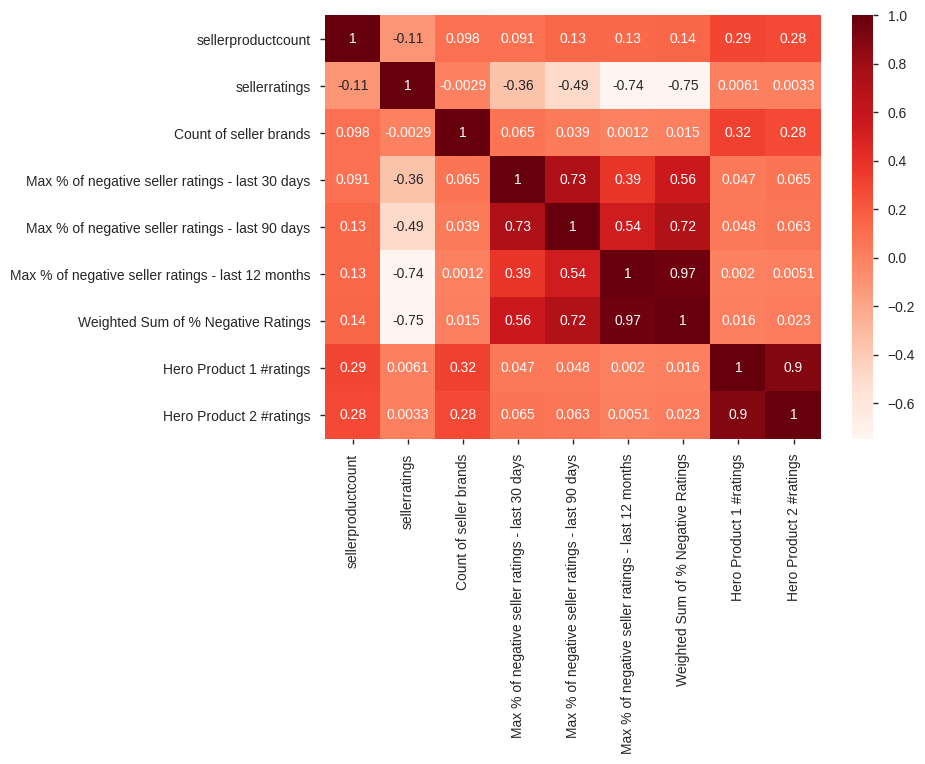

In [103]:
#Displaying a Heat map to get an inclusive understanding of correlations among features

correlation = parsed_data.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)

### **Key Observations**

1. Strong positive correlation between Hero product 1 and Hero Product 2 (0.91)

2. Some positive correlation between Count of seller brands and Hero products (0.29 and 0.26)

3. Some positive correlation between Seller product count and Hero products (0.2 each)

4. Substantial negative correlation between Seller ratings and Max % of negative seller ratings, including weighted
   sum (-0.26, -0.46, -0.76, -0.75)

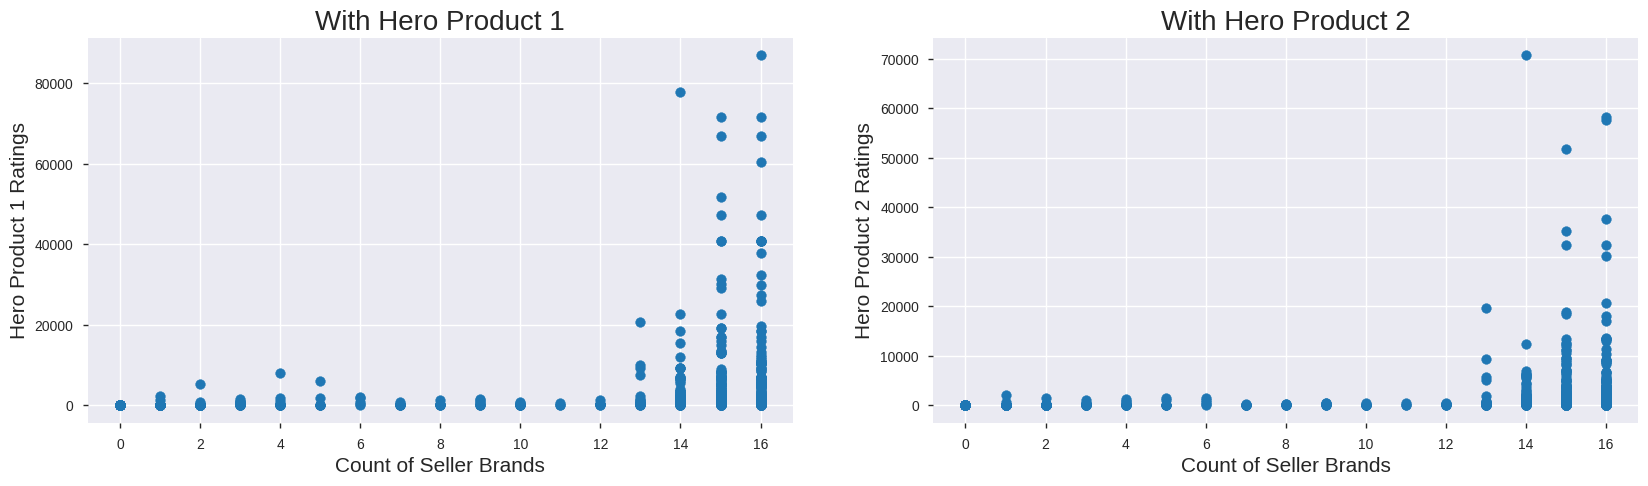

In [104]:
#Plotting Count of Seller Brands with Hero Product 1 and Hero Product 2 ratings to get inference

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1.scatter(x=parsed_data["Count of seller brands"],y=parsed_data["Hero Product 1 #ratings"])
ax1.set_title("With Hero Product 1", size = 20)
ax1.set_xlabel("Count of Seller Brands", size = 15)
ax1.set_ylabel("Hero Product 1 Ratings", size = 15)
ax2 = fig.add_subplot(122)
ax2.scatter(x=parsed_data["Count of seller brands"],y=parsed_data["Hero Product 2 #ratings"])
ax2.set_title("With Hero Product 2", size = 20)
ax2.set_xlabel("Count of Seller Brands", size = 15)
ax2.set_ylabel("Hero Product 2 Ratings", size = 15)
plt.show()

**Inference** - As the number of seller brands increases after a certain threshold, Hero Products tend to get more ratings (Positive correlation)

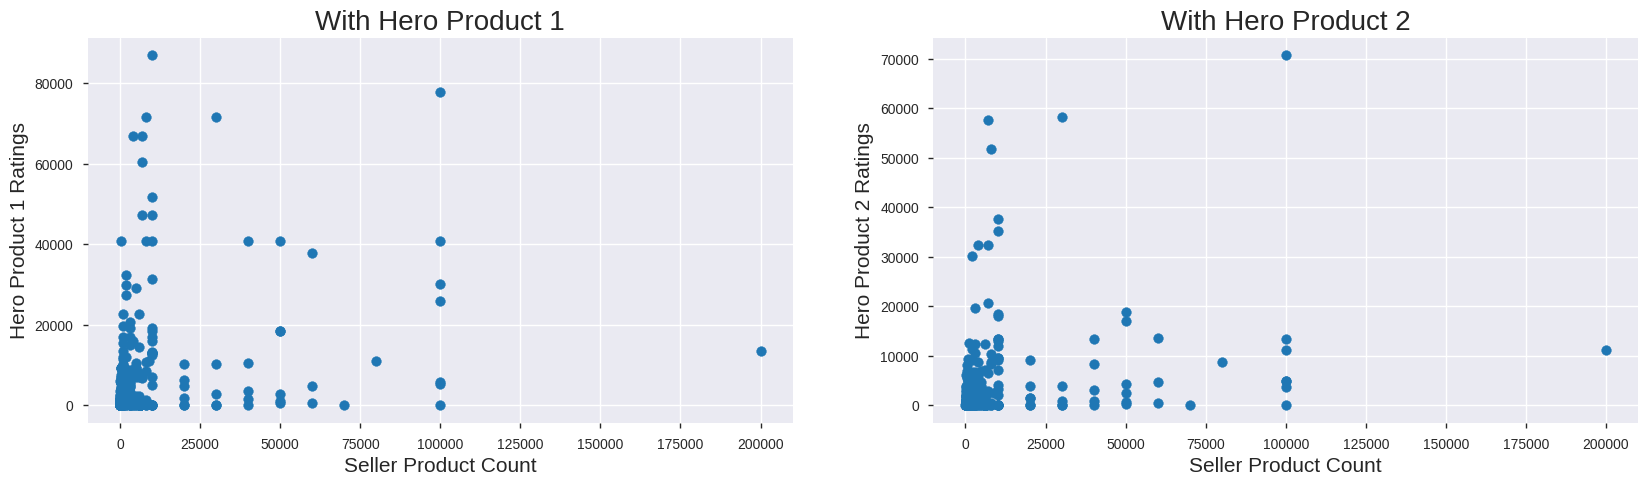

In [105]:
#Plotting Seller Product Count with Hero Product 1 and Hero Product 2 ratings to get inference

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)

ax1.scatter(x=parsed_data["sellerproductcount"],y=parsed_data["Hero Product 1 #ratings"])
ax1.set_title("With Hero Product 1", size = 20)
ax1.set_xlabel("Seller Product Count", size = 15)
ax1.set_ylabel("Hero Product 1 Ratings", size = 15)
ax2 = fig.add_subplot(122)
ax2.scatter(x=parsed_data["sellerproductcount"],y=parsed_data["Hero Product 2 #ratings"])
ax2.set_title("With Hero Product 2", size = 20)
ax2.set_xlabel("Seller Product Count", size = 15)
ax2.set_ylabel("Hero Product 2 Ratings", size = 15)
plt.show()

**Inference** - No clear relation can be determined here due to varying densities of observations in different regions of the 2 graphs 

Text(0, 0.5, 'Seller Rating')

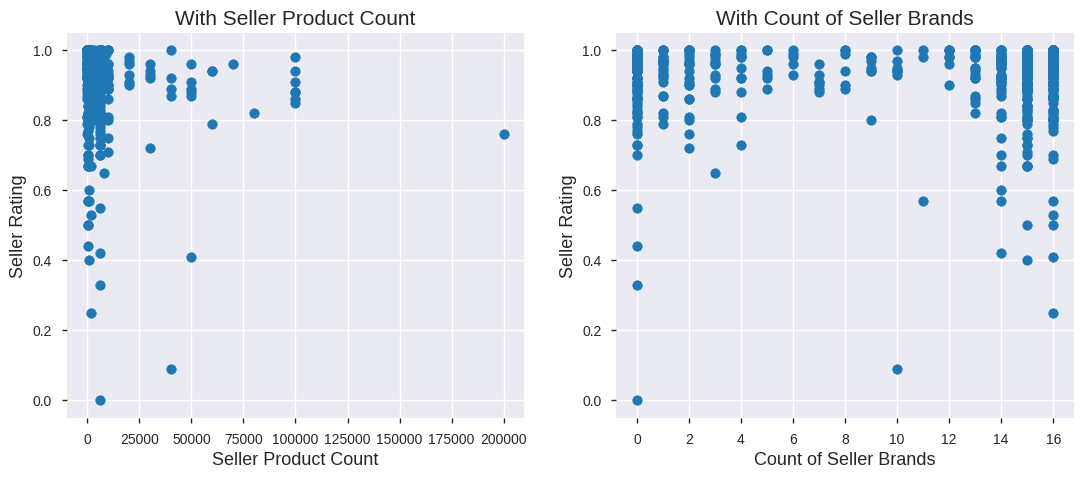

In [106]:
#Plotting Seller Ratings with Seller Product Count and Count of Seller Brands to get inference

fig = plt.figure(figsize = (13,5))
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)

xvar1 = parsed_data["sellerproductcount"]
yvar1 = parsed_data["sellerratings"]

xvar2 = parsed_data["Count of seller brands"]
yvar2 = parsed_data["sellerratings"]

a1.scatter(xvar1,yvar1)
a2.scatter(xvar2,yvar2)

a1.set_title("With Seller Product Count", size = 15)
a1.set_xlabel("Seller Product Count", size = 13)
a1.set_ylabel("Seller Rating", size = 13)

a2.set_title("With Count of Seller Brands", size = 15)
a2.set_xlabel("Count of Seller Brands", size = 13)
a2.set_ylabel("Seller Rating", size = 13)


**Inference** - If the Count of Seller Brands is too high or too low, the dispersion of Seller Ratings increases; an optimal interval of Count in the middle gives a tight Seller Rating (above 0.8)

Text(0, 0.5, 'Max % Negative (12 months)')

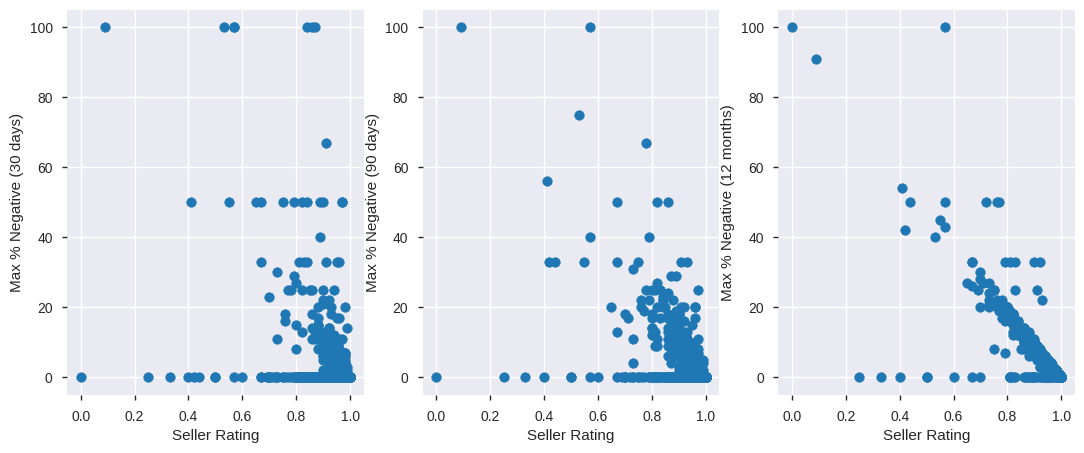

In [112]:
#Plotting each Max % Negative Rating (30 days, 90 days and 12 months) with Seller Ratings to get inference

fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

x1 = parsed_data["sellerratings"]
y1 = parsed_data["Max % of negative seller ratings - last 30 days"]

x2 = parsed_data["sellerratings"]
y2 = parsed_data["Max % of negative seller ratings - last 90 days"]

x3 = parsed_data["sellerratings"]
y3 = parsed_data["Max % of negative seller ratings - last 12 months"]

ax1.scatter(x1,y1)
ax2.scatter(x2,y2)
ax3.scatter(x3,y3)

ax1.set_xlabel('Seller Rating')
ax1.set_ylabel('Max % Negative (30 days)')

ax2.set_xlabel('Seller Rating')
ax2.set_ylabel('Max % Negative (90 days)')

ax3.set_xlabel('Seller Rating')
ax3.set_ylabel('Max % Negative (12 months)')


**Inference** - For low values of Max % Negative Ratings, we get a high Seller Ratings

In [117]:
#Creating a new feature - No. of Products per brand to determine Brand Intensity 

parsed_data["No. of Products per brand"] = parsed_data["sellerproductcount"]/parsed_data["Count of seller brands"]
values = parsed_data[parsed_data["No. of Products per brand"] != float('inf')]["No. of Products per brand"]

parsed_data.head()

,sellerproductcount,sellerratings,selleremails,sellerphonenumber,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Weighted Sum of % Negative Ratings,Hero Product 1 #ratings,Hero Product 2 #ratings,No. of Products per brand
0,100000.000000,0.880000,jadgemaello@gmail.com,"[10022-6630, +1208-964-6807, 10022-6630, +1208...",411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,12.125,5873,4957,6250.000000
1,6150.933245,0.900000,info@1a-handelsagentur.de,"[39932-829721, 39932 - 829721]",1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,7.250,1,1,inf
14,919.000000,0.970000,webmaster@9pm-store.de,[15140008562],Kaiserstr.12Borgholzhausen33829DE,15,0,0,3,2.250,1446,921,61.266667
19,6150.933245,0.760000,abc-markt@web.de,no phone,Jösser Weg10Petershagen32469DE,0,18,20,20,19.875,1,1,inf
20,123.000000,0.809837,no email,no phone,WEXFORDGOREY46 MAIN STY25T2N4IE,14,0,0,0,0.000,837,787,8.785714


In [118]:
#Descriptive statistics of our new feature

print("Total values (Non-Infinite):  ",len(values))
print("Mean of values:               ",values.mean())
print("Standard Deviation of values: ",values.std())


Total values (Non-Infinite):   433
Mean of values:                686.336232314004
Standard Deviation of values:  3746.033989107144


In [119]:
#Since our new feature has a skewed distribution, it is important to eliminate sparse observations above 1000 and plot the more dense
#region i.e. values below 1000 

shaved_values = values[values < 1000]
len(shaved_values)

392

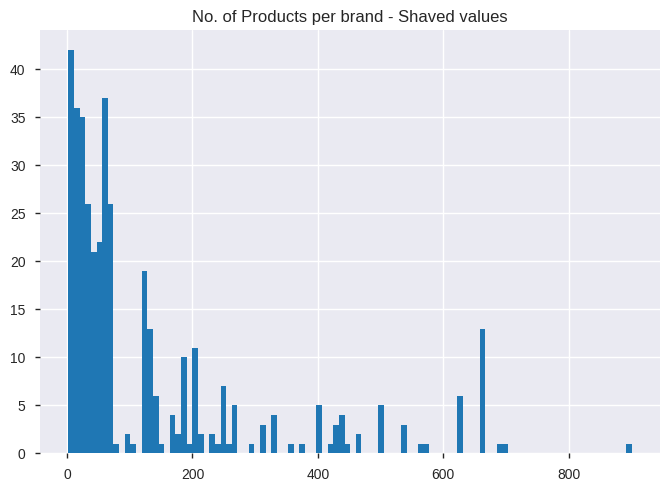

In [120]:
#Plotting the shaved values (below 1000) to get a better sense of distribution

plt.hist(shaved_values, bins = 100)
plt.title("No. of Products per brand - Shaved values")
plt.show()


## **Selection Criteria**

In order to determine whether a seller is good for investment, the proposed selection criteria evaluates each seller with 3 tests.

In order to be deemed worthy of investment, 2 or more of these tests have to be passed.

### **Test 1 - Negative Ratings % Barrier**

**Feature used**: Max % of Negative Seller Ratings (30 days, 90 days and 12 months) 

**Rationale**:


*   E-commerce companies use the negative feedback rating as an internal (non customer-facing) measure. It is calculated by dividing orders with negative feedback by the total number of orders for a period.
*   The best sellers average at a 0% negative feedback. However, anything between 0% and 2% is considered "great." Anything greater than 5% is a cause for concern.

**Evaluation Criteria**:


*   Hypothesis testing can be used for each observation and all three ratings (30 days, 90 days and 12 months) are tested separately at a significance level of 10%; hence three tests for each seller
*   Test Statistics can be calculated for each individual rating by taking the difference of the rating in consideration and 2%, and then dividing it by the standard deviation of the whole column
*   Sample Test Statistic for observation i = (2% - Negative Rating % 30 days(i))/Standard Deviation of all ratings in 30 days column
*   This test statistic is compared with the critical value (1.28); if the absolute value of test statistic is greater than 1.28, then the rating is significantly different from 2%
*   After conducting individual hypothesis tests for each time period (30 days, 90 days and 12 months), a majority voting is applied to determine the final result for a seller
*   Two or more tests have to be statistically significant in order to label the seller as having "Significant Negative Ratings"
*   If a seller gets "Significant Negative Ratings" (from majority voting), the seller will fail the Test
*   Only those sellers that do not receive Significant Negative Ratings" will pass the test

In [121]:
#Making a new Dataframe for Test 1 with the features in consideration

test_1 = parsed_data[["Max % of negative seller ratings - last 30 days","Max % of negative seller ratings - last 90 days","Max % of negative seller ratings - last 12 months"]]

#Making new columns for Test Statistics

test_1["Test Statistic 1"] = (2 - test_1["Max % of negative seller ratings - last 30 days"])/test_1["Max % of negative seller ratings - last 30 days"].std(axis=None)
test_1["Test Statistic 2"] = (2 - test_1["Max % of negative seller ratings - last 90 days"])/test_1["Max % of negative seller ratings - last 90 days"].std(axis=None)
test_1["Test Statistic 3"] = (2 - test_1["Max % of negative seller ratings - last 12 months"])/test_1["Max % of negative seller ratings - last 12 months"].std(axis=None)

test_1.head()


,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Test Statistic 1,Test Statistic 2,Test Statistic 3
0,17,11,12,-1.008518,-0.814510,-0.894970
1,2,2,9,0.000000,0.000000,-0.626479
14,0,0,3,0.134469,0.181002,-0.089497
19,18,20,20,-1.075753,-1.629020,-1.610945
20,0,0,0,0.134469,0.181002,0.178994


In [122]:
##Comparing the test statistics for each column with the critical values and storing the result in Result columns

#If the absolute value of test statistic is greater than critical value, the result is significant. "Sig" is stored in the result column

test_1.loc[abs(test_1["Test Statistic 1"]) > 1.28, "Result 1"] = "Sig"
test_1.loc[abs(test_1["Test Statistic 2"]) > 1.28, "Result 2"] = "Sig"
test_1.loc[abs(test_1["Test Statistic 3"]) > 1.28, "Result 3"] = "Sig"

#If the absolute value of test statistic is less than the critical value, the result is not significant. "No_Sig" is stored in the result column

test_1.loc[abs(test_1["Test Statistic 1"]) < 1.28, "Result 1"] = "No_Sig"
test_1.loc[abs(test_1["Test Statistic 2"]) < 1.28, "Result 2"] = "No_Sig"
test_1.loc[abs(test_1["Test Statistic 3"]) < 1.28, "Result 3"] = "No_Sig"

#The final decision for all the three time periods is determined through majority voting and the majority result (Sig or No_Sig) is stored in the Final Result column

Res = ["Result 1", "Result 2", "Result 3"]
test_1["Final Result"]= test_1[Res].mode(axis=1, dropna = False)


In [123]:
test_1.head()

,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Test Statistic 1,Test Statistic 2,Test Statistic 3,Result 1,Result 2,Result 3,Final Result
0,17,11,12,-1.008518,-0.814510,-0.894970,No_Sig,No_Sig,No_Sig,No_Sig
1,2,2,9,0.000000,0.000000,-0.626479,No_Sig,No_Sig,No_Sig,No_Sig
14,0,0,3,0.134469,0.181002,-0.089497,No_Sig,No_Sig,No_Sig,No_Sig
19,18,20,20,-1.075753,-1.629020,-1.610945,No_Sig,Sig,Sig,Sig
20,0,0,0,0.134469,0.181002,0.178994,No_Sig,No_Sig,No_Sig,No_Sig


### **Test 2 - Count of Seller Brands Barrier**

**Feature used**: Count of Seller Brands

**Rationale**:

*   When we plot Count of Seller Brands and Seller Ratings together, we observe an interesting relation 
*   For low values (<4) and high values (>12) of Count of Seller Brands, the dispersion in Seller Ratings increases whereas for Count values in the central region, the Seller Ratings remain within a tight band (between 0.8 and 1.0)
*   This implies that having too few or too many Count of Seller Brands can be risky as the Seller Ratings fluctuate too much 
*   As parsed before, only the positivity rate is used in the Seller Rating column (% of positive ratings); positivity rate is an excellent condition for making an investment

**Evaluation Criteria**:

*   Count values corresponding to various percentiles are found, and those percentiles which designate our desired count (4 to 12) are determined
*  Percentile ranks of each seller are calculated and compared with our optimal interval
*  Percentiles lying outside our desired band are not good for investment as the seller ratings show high dispersion
*  Count percentiles within our band signal good investment opportunities

In [134]:
#Making a new Dataframe for Test 2 with the features in consideration

test_2 = parsed_data[["sellerratings","Count of seller brands"]]
count = test_2["Count of seller brands"]

#Creating a new column with the percentiles of each value in the Count of seller brands column

test_2["Percentile Rank"] = count.rank(pct=True) 

test_2.head()

,sellerratings,Count of seller brands,Percentile Rank
0,0.880000,16,0.883810
1,0.900000,0,0.088571
14,0.970000,15,0.647619
19,0.760000,0,0.088571
20,0.809837,14,0.483810


In [135]:
#As plotted in the Analysis of Sanitized Dataset section, very low (<4) and very high (>12) values of Count of seller brands result in high dispersion/variability in Seller ratings 
#Values of Count of seller brands in the middle region correspond to a tight band of Seller ratings (0.8 to 1.0)

#Finding the respective count for each percentile

print("10th percentile of count:    ", count.quantile(0.1))
print("20th percentile of count:    ", count.quantile(0.2))
print("30th percentile of count:    ", count.quantile(0.3)) #To use
print("40th percentile of count:    ", count.quantile(0.4)) #To use
print("50th percentile of count:    ", count.quantile(0.5))

#The interval between 30th percentile and 40th percentile correspond to Count of seller brands between 4 and 12 respectively i.e. our optimal count of brands 


10th percentile of count:     0.0
20th percentile of count:     1.0
30th percentile of count:     4.0
40th percentile of count:     12.600000000000023
50th percentile of count:     14.0


In [136]:
#Creating a new column "Optimal Count" which displays "Yes" if the Count lies between 30th and 40th percentile

test_2.loc[(test_2["Percentile Rank"] > 0.3), "Optimal Count"] = "Yes" 
test_2.loc[(test_2["Percentile Rank"] < 0.4), "Optimal Count"] = "Yes" 
test_2.loc[(test_2["Percentile Rank"] <= 0.3), "Optimal Count"] = "No"
test_2.loc[(test_2["Percentile Rank"] >= 0.4), "Optimal Count"] = "No"

test_2.head()

,sellerratings,Count of seller brands,Percentile Rank,Optimal Count
0,0.880000,16,0.883810,No
1,0.900000,0,0.088571,No
14,0.970000,15,0.647619,No
19,0.760000,0,0.088571,No
20,0.809837,14,0.483810,No


### **Test 3 - No. of Products per Brand Barrier**

**Feature used**: No. of Products per Brand 

**Rationale**:

*   In order to determine the Brand Intensity, a helpful metric can be average number of products per brand (our engineered feature)
*   It has been observed, that the higher the number of products a brand has, the more customer attraction and retention can be achieved
*   High customer attraction and retention over a long period lead to stable and increasing revenues

**Evaluation Criteria**:


*   No. of Products per brand corresponding to several percentiles above the median are calculated
*   The 75th percentile (3rd quartile) is chosen as the cut-off value or threshold; sellers having products per brand above this threshold can be labelled as having "High Brand Intensity" 
*   High Brand Intensity signals strong market presence; or increased monopoly of seller
*   Sellers with "High Brand Intensity" are a green flag for investment

In [137]:
#Making a new Dataframe with our engineered feature - No. of Products per brand

test_3 = pd.DataFrame(parsed_data["No. of Products per brand"])

#Filling NaN values with the median

test_3[test_3["No. of Products per brand"] == float("inf")] = np.nan

test_3["No. of Products per brand"] = test_3["No. of Products per brand"].fillna(test_3["No. of Products per brand"].median())

test_3.head()

,No. of Products per brand
0,6250.000000
1,63.000000
14,61.266667
19,63.000000
20,8.785714


In [138]:
#Evaluating the No.of Products per brand for various percentiles above the median

print("50th percentile of No. of Products per brand: ",test_3["No. of Products per brand"].quantile(0.50))
print("60th percentile of No. of Products per brand: ",test_3["No. of Products per brand"].quantile(0.60))
print("70th percentile of No. of Products per brand: ",test_3["No. of Products per brand"].quantile(0.70))
print("80th percentile of No. of Products per brand: ",test_3["No. of Products per brand"].quantile(0.80))
print("90th percentile of No. of Products per brand: ",test_3["No. of Products per brand"].quantile(0.90))


50th percentile of No. of Products per brand:  63.0
60th percentile of No. of Products per brand:  66.66666666666667
70th percentile of No. of Products per brand:  133.33333333333334
80th percentile of No. of Products per brand:  250.80000000000018
90th percentile of No. of Products per brand:  666.6666666666666


In [139]:
#Labelling sellers having No. of Products per brand above 75th percentile (3rd quartile) as having High Brand Intensity

test_3.loc[(test_3["No. of Products per brand"] > test_3["No. of Products per brand"].quantile(0.75) ), "High Intensity"] = "Yes"
test_3.loc[(test_3["No. of Products per brand"] < test_3["No. of Products per brand"].quantile(0.75) ), "High Intensity"] = "No"

test_3.head()

,No. of Products per brand,High Intensity
0,6250.000000,Yes
1,63.000000,No
14,61.266667,No
19,63.000000,No
20,8.785714,No


### **Final Investment Decision**

In [140]:
#Making our final decision dataframe containing the outcome columns of the three tests - Final Result (Test 1), Optimal Count (Test 2) and High Intensity (Test 3)

Final_Decision = pd.DataFrame()
Final_Decision["Seller Emails"] = parsed_data["selleremails"]
Final_Decision["Seller Phone Numbers"] = parsed_data["sellerphonenumber"]
Final_Decision["Barrier 1"] = test_1["Final Result"]
Final_Decision["Barrier 2"] = test_2["Optimal Count"]
Final_Decision["Barrier 3"] = test_3["High Intensity"]

#Encoding our columns to get the final score

Final_Decision.loc[Final_Decision["Barrier 1"] == "No_Sig", "Barrier 1"] = 1
Final_Decision.loc[Final_Decision["Barrier 1"] == "Sig", "Barrier 1"] = 0

Final_Decision.loc[Final_Decision["Barrier 2"] == "No", "Barrier 2"] = 0
Final_Decision.loc[Final_Decision["Barrier 2"] == "Yes", "Barrier 2"] = 1

Final_Decision.loc[Final_Decision["Barrier 3"] == "No", "Barrier 3"] = 0
Final_Decision.loc[Final_Decision["Barrier 3"] == "Yes", "Barrier 3"] = 1

#Creating a sum column

Final_Decision["Sum of Barriers"] = Final_Decision["Barrier 1"] + Final_Decision["Barrier 2"] + Final_Decision["Barrier 3"]

#Creating an investment decision column where passing 2 or more tests corresponds to a value >= 2 in the Sum of Barriers column

Final_Decision.loc[(Final_Decision["Sum of Barriers"] >= 2 ), "Investment Decision"] = "Yes"
Final_Decision.loc[(Final_Decision["Sum of Barriers"] < 2 ), "Investment Decision"] = "No"

print("Total sellers worthy of investment:",(Final_Decision["Sum of Barriers"] >= 2).sum())

Final_Decision.head()

Total sellers worthy of investment: 152


,Seller Emails,Seller Phone Numbers,Barrier 1,Barrier 2,Barrier 3,Sum of Barriers,Investment Decision
0,jadgemaello@gmail.com,"[10022-6630, +1208-964-6807, 10022-6630, +1208...",1,0,1,2,Yes
1,info@1a-handelsagentur.de,"[39932-829721, 39932 - 829721]",1,0,0,1,No
14,webmaster@9pm-store.de,[15140008562],1,0,0,1,No
19,abc-markt@web.de,no phone,0,0,0,0,No
20,no email,no phone,1,0,0,1,No


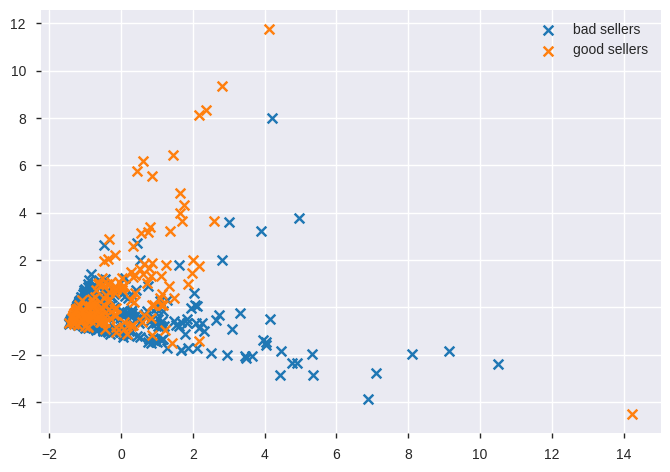

In [141]:
#Plotting our clusters 

plt.scatter(pca_reduced[Final_Decision["Sum of Barriers"] < 2][:,0], pca_reduced[Final_Decision["Sum of Barriers"] < 2][:,1], label="bad sellers", marker = 'x')
plt.scatter(pca_reduced[Final_Decision["Sum of Barriers"] >= 2][:,0], pca_reduced[Final_Decision["Sum of Barriers"] >= 2][:,1], label="good sellers", marker = 'x')
plt.legend()
plt.show()

In [142]:
#Sellers not worthy of investment
pca_reduced[Final_Decision["Sum of Barriers"] < 2].shape

(364, 2)

In [143]:
#Sellers worthy of investment
pca_reduced[Final_Decision["Sum of Barriers"] >= 2].shape

(152, 2)